## Exploratory Data Analysis

In this step we will do some data analysis, we will see the percentage of malicious records contained in the data. Also, we will see how many network flows for each attack type. In addition, we will see if there is a correlation between features and if there is a strong correlation between features and the binary class(if the network flow benign or malicious).

### Dataset Preparation

At the begining, we will import all the dataset from all the files(which includes all different types of attacks) and we will define the data type for each column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats
from scipy.stats import ks_2samp

%matplotlib inline

In [2]:
# set base path to the directory containing the csv files of the dataset
dataset_base_path = r'processed'

In [3]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = pd.concat((pd.read_csv(f) for f in csv_files))

In [7]:
#columns with negative values
numeric_cols = df.select_dtypes(include=[np.number]).columns.values
columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
columns

['flow_duration',
 'flow_pkts_s',
 'flow_iat_mean',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_tot',
 'fwd_iat_mean',
 'fwd_iat_max',
 'fwd_iat_min',
 'init_fwd_win_byts',
 'init_bwd_win_byts']

In [21]:
df.init_fwd_win_byts.value_counts()

 8192.000000     10255064
 12088.350041     4432608
-1.000000         4432608
 65535.000000     1090632
 32738.000000     1044530
                   ...   
 18580.000000           2
 18575.000000           2
 18553.000000           2
 18552.000000           2
 14936.000000           2
Name: init_fwd_win_byts, Length: 16047, dtype: int64

In [22]:
df[df.flow_iat_min<0].count()

Unnamed: 0          0
dst_port           15
protocol           15
timestamp          15
flow_duration      15
                   ..
idle_max           15
idle_min           15
label              15
label_code          0
label_is_attack     0
Length: 83, dtype: int64

In [54]:
df.shape

(16232943, 82)

#### Filling missing values

Here, we will see the columns which have infinity values and replace them with the mean of that column.

In [7]:
inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]

print(f'Columns containing infinity values {inf_columns}')

Columns containing infinity values ['flow_byts_s', 'flow_pkts_s']


In [8]:
for col in inf_columns:
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    mean = df[col].mean()
    df[col].fillna(mean, inplace=True)

In [47]:
def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

In [48]:
df = replace_negative_values_with_mean(df)

In [49]:
df.shape

(16232943, 80)

Here, we will create new columns one to know if the record is benign or malicious and another columns to see which type of attacks the record is.

In [51]:
df['label'] = df.label.astype('category')
df['label_code'] = df['label'].cat.codes
df['label_is_attack'] = df.label.apply(lambda x: 0 if x == 'Benign' else 1)

In [ ]:
tmp_file_path = os.path.join(dataset_base_path, 'all_data.csv')

df.to_csv(tmp_file_path)

In [12]:
df.label.value_counts()

Benign                      13484708
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193360
SSH-Bruteforce                187589
Infilteration                 161934
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: label, dtype: int64

In [11]:
df.label_code.value_counts()

0     13484708
4       686012
6       576191
8       461912
1       286191
11      193360
14      187589
12      161934
9       139890
7        41508
10       10990
5         1730
2          611
3          230
13          87
Name: label_code, dtype: int64

In [13]:
df.label_is_attack.value_counts()

0    13484708
1     2748235
Name: label_is_attack, dtype: int64

In [14]:
attack_types = [a for a in df.label.value_counts().index.tolist() if a != 'Benign']

for a in attack_types:
    l = 'label_is_attack_' + a.replace('-', ' ').replace(' ', '_').lower()
    df[l] = df.label.apply(lambda x: 1 if x == a else 0)

In [15]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,label_is_attack_ftp_bruteforce,label_is_attack_ssh_bruteforce,label_is_attack_infilteration,label_is_attack_dos_attacks_slowhttptest,label_is_attack_dos_attacks_goldeneye,label_is_attack_dos_attacks_slowloris,label_is_attack_ddos_attack_loic_udp,label_is_attack_brute_force__web,label_is_attack_brute_force__xss,label_is_attack_sql_injection
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773,202,0,...,0,0,0,0,0,0,0,0,0,0
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0,38,0,...,0,0,0,0,0,0,0,0,0,0
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527,385,0,...,0,0,0,0,0,0,0,0,0,0
3,443,6,02/03/2018 08:47:40,132,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141,517,0,...,0,0,0,0,0,0,0,0,0,0


#### Dataset Overview

Here, we see that the whole dataset consists of *16232943* network flows and that there is no all `null` values.

In [16]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 613070
Data columns (total 96 columns):
 #   Column                                    Non-Null Count     Dtype   
---  ------                                    --------------     -----   
 0   dst_port                                  16232943 non-null  uint32  
 1   protocol                                  16232943 non-null  uint8   
 2   timestamp                                 16232943 non-null  object  
 3   flow_duration                             16232943 non-null  int64   
 4   tot_fwd_pkts                              16232943 non-null  uint32  
 5   tot_bwd_pkts                              16232943 non-null  uint32  
 6   totlen_fwd_pkts                           16232943 non-null  uint32  
 7   totlen_bwd_pkts                           16232943 non-null  uint32  
 8   fwd_pkt_len_max                           16232943 non-null  uint16  
 9   fwd_pkt_len_min                           16232943 non-nu

### Data Analysis and Visualization

1. Number and percentage of benign network flows in relation to malicious flows


<AxesSubplot:xlabel='label_is_attack', ylabel='count'>

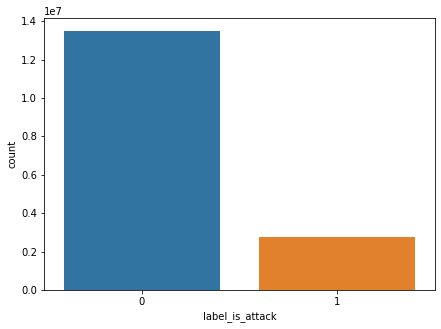

In [17]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='label_is_attack', data=df, order = df['label_is_attack'].value_counts().index, ax=ax)

Here, we see that there is around to .83% of the data is benign network flows which means that we have very small number of malicious flows.

In [18]:
df_is_attack = df.groupby('label_is_attack').agg({'label_is_attack':'first', 'label_is_attack':'count'}).rename_axis(None).sort_values('label_is_attack', ascending=False)
df_is_attack['percentage'] = df_is_attack / df_is_attack.loc[:'label_is_attack'].sum()
df_is_attack

,label_is_attack,percentage
0,13484708,0.8307
1,2748235,0.1693


 2. Number of flows per attack type

The following graph shows the number of flows accounting for the different attack types. 
The graph shows that the following types has no much data:
* DoS attacks-GoldenEye
* DoS attacks-Slowloris
* DDOS attack-LOIC-UDP
* Brute Force-Web
* Brute Force-XSS
* SQL Injection 
This means that it might be difficult to train a multi-class classifier to detect those kinds of network traffic.

<AxesSubplot:xlabel='count', ylabel='label'>

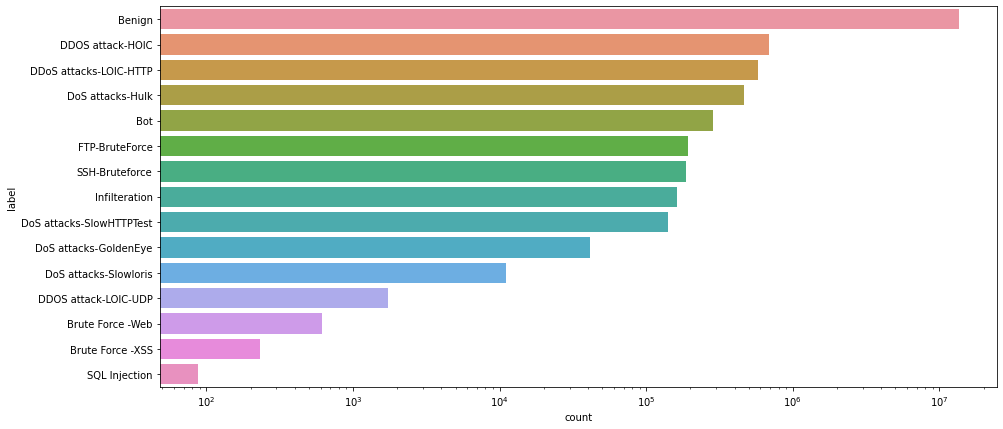

In [24]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale='log')
sns.countplot(y='label', data=df, order = df['label'].value_counts().index, ax=ax)

3. Correlation between Features

Here, we will do a heatmap to see the correlation between all features.
We see that there is a strong correlations between some of feature-pairs.

For example, `tot_fwd_pkts` (Total packets in the forward direction) and `fwd_header_len` (Total bytes used for headers in the forward direction) which makes sense as an increase in the number of packets leads to a higher number of bytes used as headers.

In [25]:
corr = df.drop(columns=['label', 'timestamp']).corr()

<AxesSubplot:>

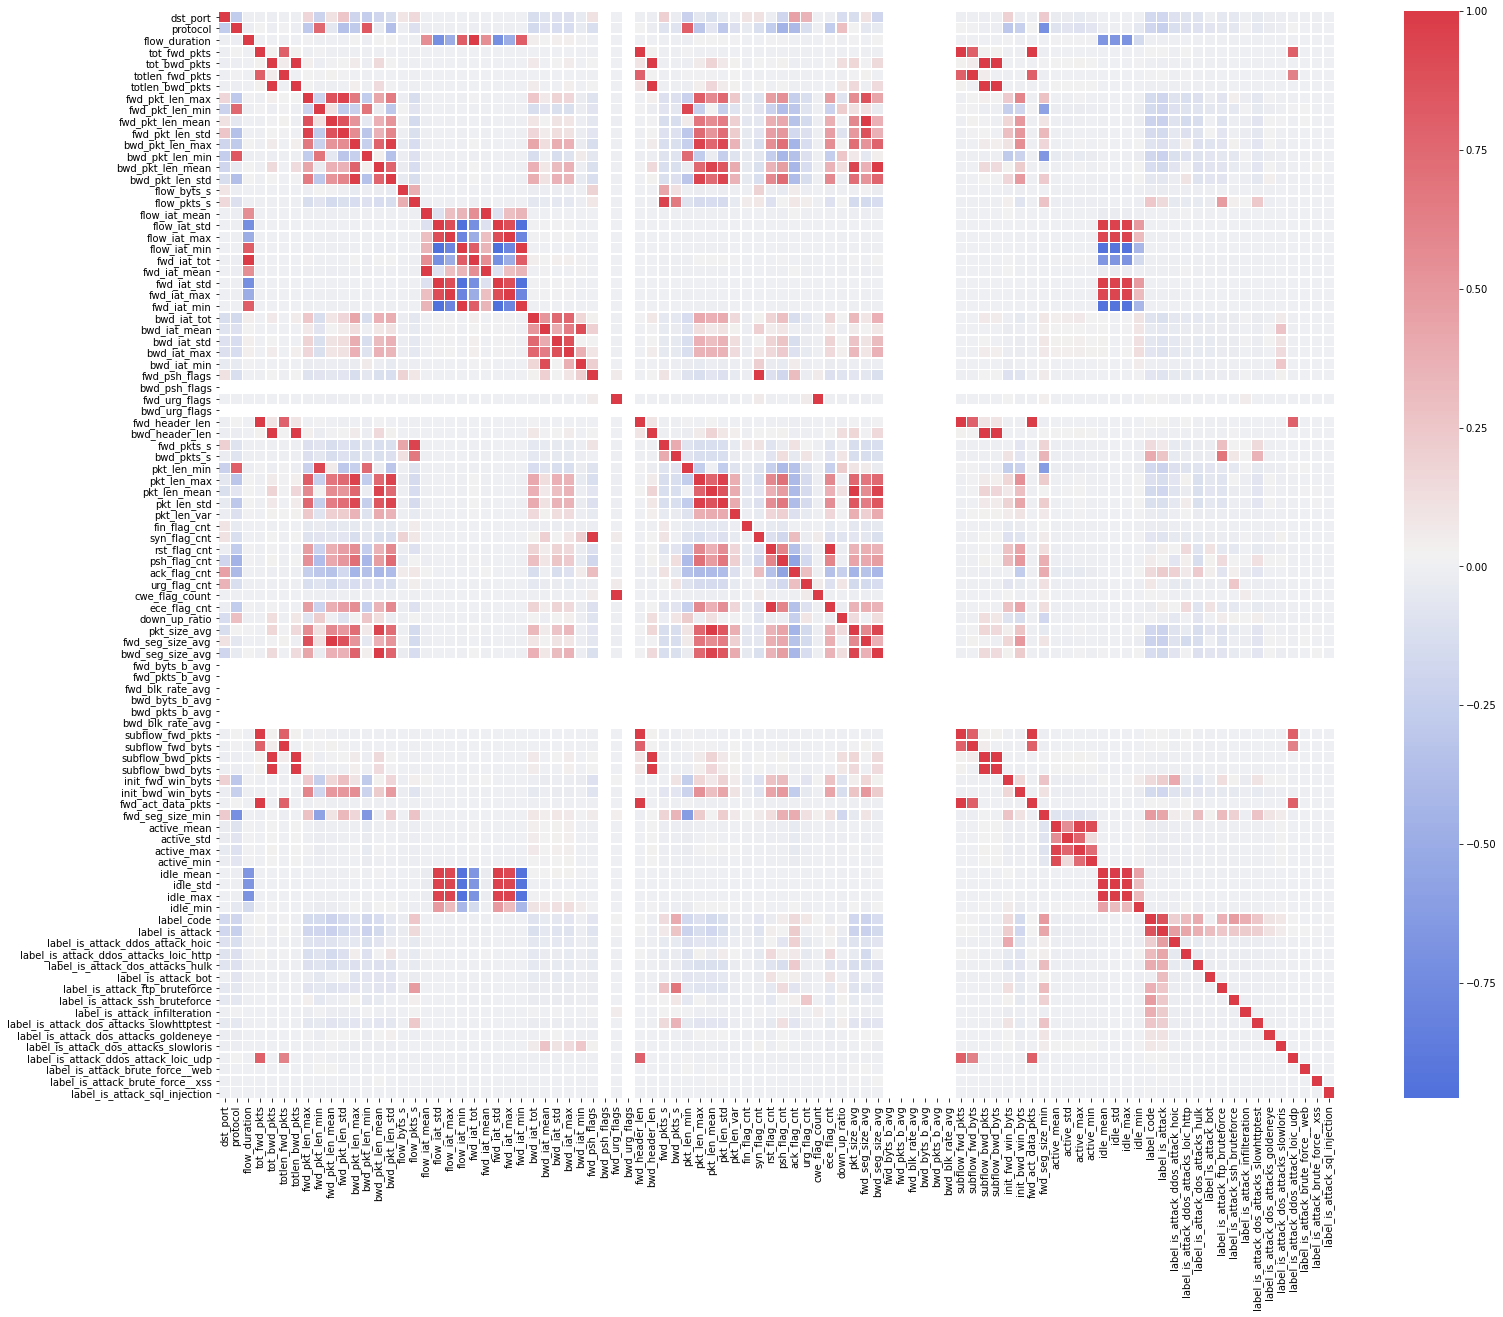

In [26]:
plt.figure(figsize=(25, 20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

#### Strong correlations 

Next we will see the pair of features which have correlations with an absolute value > 0.8, those features seems to be redundant and can be removed. This helps us in feature selection for the modeling stage. 

In [27]:
def get_abs_correlations(df, t):
    labels_to_drop = set()
    cols = df.columns.drop(['label', 'timestamp'])
    for i in range(0, df.shape[1]-2):
        for j in range(0, i+1):
            labels_to_drop.add((cols[i], cols[j]))
    
    c = corr.abs().unstack().drop(labels=labels_to_drop).sort_values(ascending=False)
    return c[c > t]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(get_abs_correlations(df, 0.8))

fwd_urg_flags     cwe_flag_count       1.000000
tot_fwd_pkts      subflow_fwd_pkts     1.000000
fwd_pkt_len_mean  fwd_seg_size_avg     1.000000
tot_bwd_pkts      subflow_bwd_pkts     1.000000
totlen_fwd_pkts   subflow_fwd_byts     1.000000
fwd_psh_flags     syn_flag_cnt         1.000000
bwd_pkt_len_mean  bwd_seg_size_avg     1.000000
totlen_bwd_pkts   subflow_bwd_byts     1.000000
flow_iat_min      fwd_iat_min          0.999996
flow_iat_max      fwd_iat_max          0.999994
rst_flag_cnt      ece_flag_cnt         0.999987
flow_duration     fwd_iat_tot          0.999986
flow_iat_std      fwd_iat_std          0.999981
flow_iat_mean     fwd_iat_mean         0.999963
subflow_fwd_pkts  fwd_act_data_pkts    0.999189
tot_fwd_pkts      fwd_act_data_pkts    0.999189
bwd_header_len    subflow_bwd_pkts     0.997798
tot_bwd_pkts      bwd_header_len       0.997798
bwd_header_len    subflow_bwd_byts     0.996040
totlen_bwd_pkts   bwd_header_len       0.996038
fwd_header_len    subflow_fwd_pkts     0

4. Correlation between Features and the binary class of network flows

Next, we will see features with the highest correlations with the binary class and we will perform basic statistics and distribution to see if those features can be used in predicting the label of the network flow.

In [28]:
corr_is_attack = corr.label_is_attack.filter(regex=r'^(?!label).*', axis=0)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(corr_is_attack[corr_is_attack.notnull()].sort_values(ascending=False)[:5])

fwd_seg_size_min     0.429296
bwd_pkts_s           0.260203
ack_flag_cnt         0.220465
init_fwd_win_byts    0.218390
flow_pkts_s          0.148600
Name: label_is_attack, dtype: float64


In [29]:
def remove_outliers(data, col, zscore_thres=3):
    return data[(np.abs(stats.zscore(data[[col]])) < zscore_thres).all(axis=1)]


def plot(fn, height, data, label, col, scale='', with_outliers=True, xlim=[], bins=10):
    fig, ax = plt.subplots(figsize=(18, height))

    d = data if with_outliers else remove_outliers(data, col)
    
    if xlim:
        ax.set_xlim(xlim)
    
    if scale:
        ax.set(xscale=scale)
    
    fn(d, label, col, ax, bins)
    plt.show()

    
def plot_box(data, label, col, scale='', with_outliers=True, xlim=[]):
    plot(lambda d, l, c, ax, b: sns.boxplot(y=l, x=c, data=d, ax=ax, orient='h', width=0.4), 2, data, label, col, scale, with_outliers, xlim)
    
    
def plot_distribution(data, label, col, scale='', with_outliers=True, xlim=[], bins=10):
    plot(lambda d, l, c, ax, b: d.groupby(l)[c].plot.hist(density=True, ax=ax, alpha=0.5, bins=b), 5, data, label, col, scale, with_outliers, xlim, bins)
    
    
def plot_stats(data, label, col, no_outliers=False):
    print(data.groupby(label)[col].describe())
    plot_box(data, label, col)
    
    
def calculate_distribution_similarity(data, label, col):
    '''
    Compare distributions by calculating the p-value for the null hypothesis that data for both categories originates from the same distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
    '''
    a = data[data[label] == 0][col]
    b = data[data[label] == 1][col]
    return ks_2samp(a, b)

Here, we will run test statistic to see if the distribution for each classes (beingn or not) for each variables which have good correlation with the binary class is the same or not. If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same else we reject the hypothesis and we consider the variable to be good in predecting if there is an attack or not.

#### Minimum segment size observed in the forward direction

`fwd_seg_size_min` might be a good predictor as the p-value for the hypothesis that values from both classes originate from the same distribution is 0 and so the distributions of the feature for each of the classes differ significantly.

                      count       mean       std  min   25%   50%   75%   max
label_is_attack                                                              
0                13484708.0  16.501569  6.757963  0.0   8.0  20.0  20.0  56.0
1                 2748235.0  25.309007  7.817982  0.0  20.0  20.0  32.0  40.0


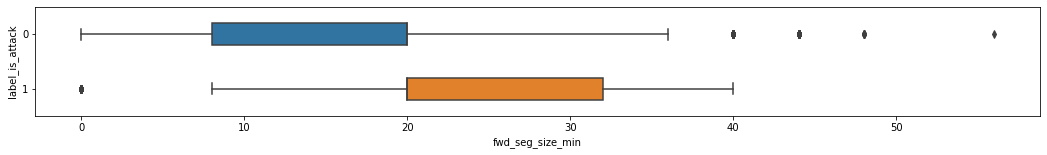

In [30]:
plot_stats(df, 'label_is_attack', 'fwd_seg_size_min')

In [31]:
calculate_distribution_similarity(df, 'label_is_attack', 'fwd_seg_size_min')

KstestResult(statistic=0.3423301956292818, pvalue=0.0)

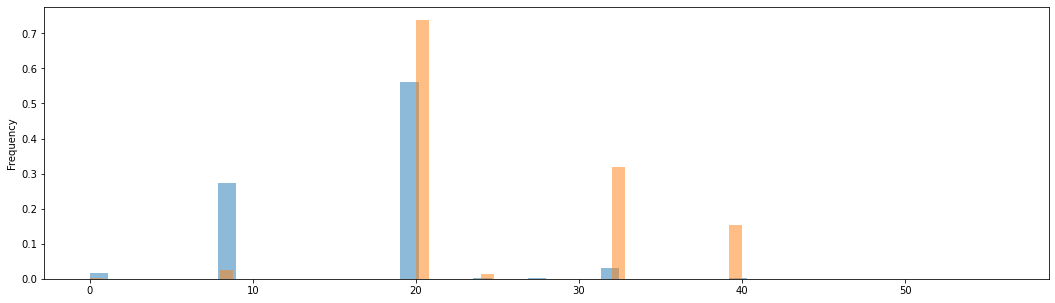

In [32]:
plot_distribution(df, 'label_is_attack', 'fwd_seg_size_min', bins=50)

#### Number of backward packets per second

`bwd_pkts_s` might also be a good predictor as the p-value for the hypothesis that values from both classes originate from the same distribution is 0 and so the distributions of the feature for each of the classes differ significantly.

                      count          mean            std  min       25%  \
label_is_attack                                                           
0                13484708.0   4408.272949   43276.777344  0.0  0.161656   
1                 2748235.0  68462.937500  200881.171875  0.0  0.000000   

                     50%         75%        max  
label_is_attack                                  
0                4.30558  882.612549  2000000.0  
1                0.00000  350.877197  2000000.0  


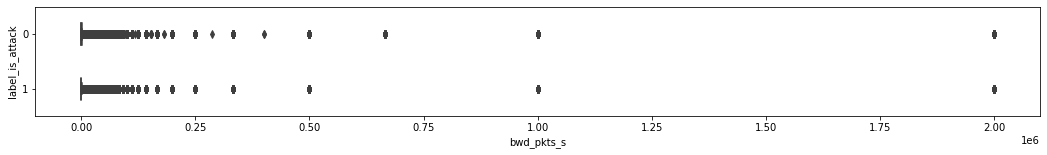

In [33]:
plot_stats(df, 'label_is_attack', 'bwd_pkts_s')

In [34]:
calculate_distribution_similarity(df, 'label_is_attack', 'bwd_pkts_s')

KstestResult(statistic=0.3205970312370562, pvalue=0.0)

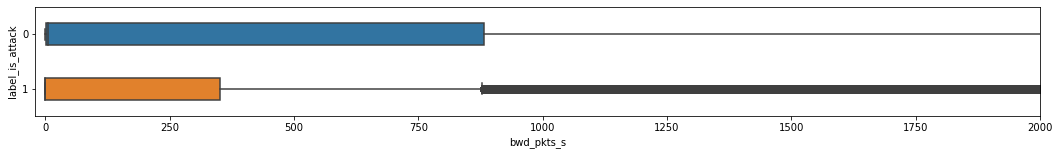

In [35]:
plot_box(df, 'label_is_attack', 'bwd_pkts_s', xlim=[-20, 2000])

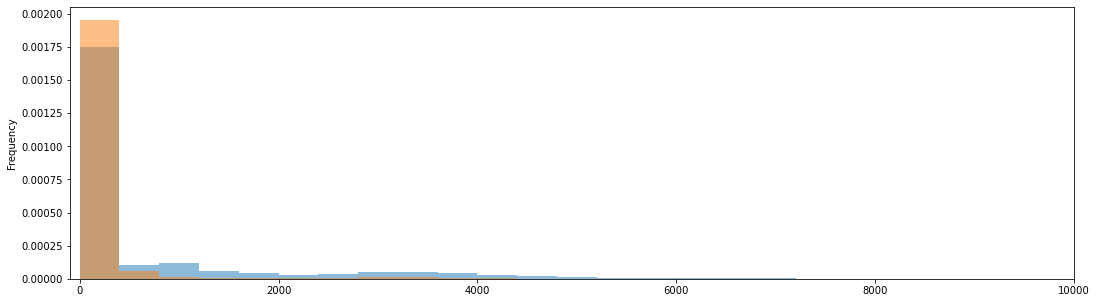

In [36]:
plot_distribution(df, 'label_is_attack', 'bwd_pkts_s', bins=5000, xlim=[-100, 10000])

### Number of packets with ACK flag

`ack_flag_cnt` might also be a good predictor as the distributions of the feature for each of the classes differ significantly and the p-value for the hypothesis that values from both classes originate from the same distribution is 0.

                      count      mean       std  min  25%  50%  75%  max
label_is_attack                                                         
0                13484708.0  0.284745  0.451293  0.0  0.0  0.0  1.0  1.0
1                 2748235.0  0.561513  0.496202  0.0  0.0  1.0  1.0  1.0


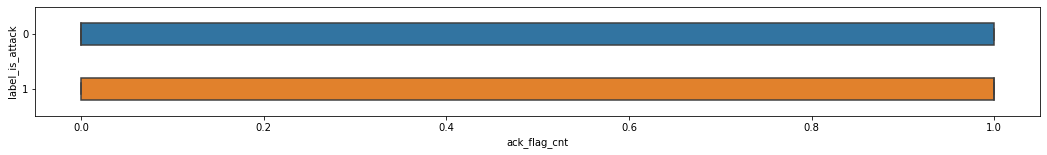

In [37]:
plot_stats(df, 'label_is_attack', 'ack_flag_cnt')

In [38]:
calculate_distribution_similarity(df, 'label_is_attack', 'ack_flag_cnt')

KstestResult(statistic=0.2767682713043731, pvalue=0.0)

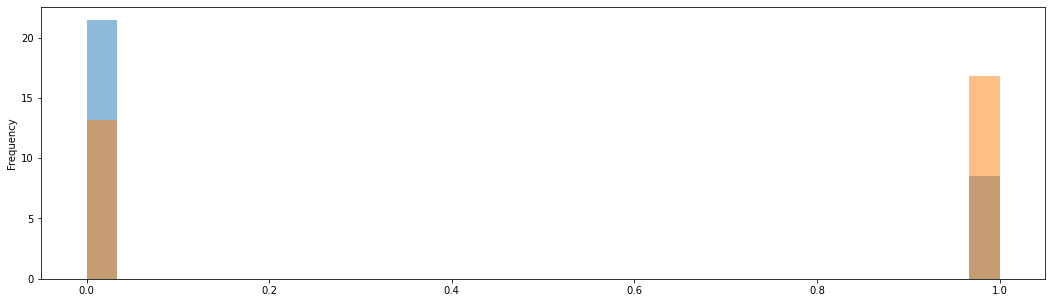

In [39]:
plot_distribution(df, 'label_is_attack', 'ack_flag_cnt', bins=30)

#### Minimum size of packet in backward direction

Finaly, `bwd_pkt_len_min` appears to be a good feature. It is also mentioned in the paper (https://www.scitepress.org/Papers/2018/66398/66398.pdf) as a good one.

                      count       mean        std  min  25%  50%   75%     max
label_is_attack                                                               
0                13484708.0  31.486992  54.162517  0.0  0.0  0.0  59.0  1460.0
1                 2748235.0   1.900770  15.138823  0.0  0.0  0.0   0.0   549.0


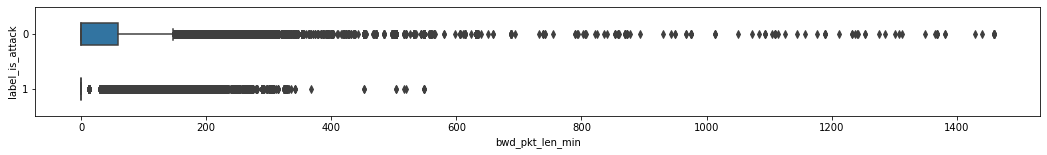

In [40]:
plot_stats(df, 'label_is_attack', 'bwd_pkt_len_min')

In [41]:
calculate_distribution_similarity(df, 'label_is_attack', 'bwd_pkt_len_min')

KstestResult(statistic=0.2895803001661078, pvalue=0.0)

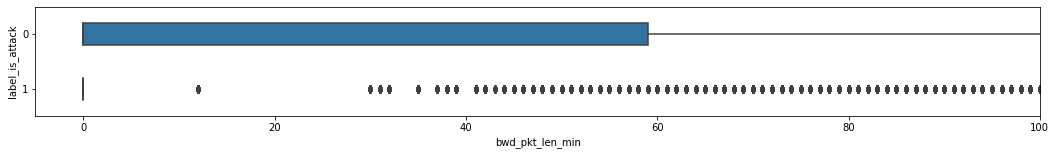

In [42]:
plot_box(df, 'label_is_attack', 'bwd_pkt_len_min', xlim=[-5, 100])

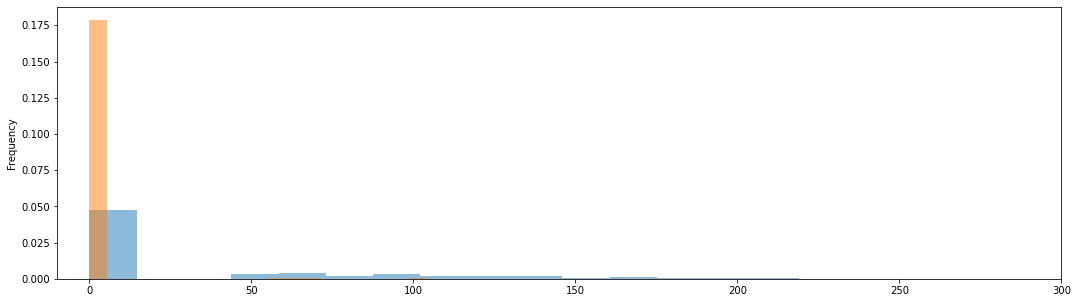

In [43]:
plot_distribution(df, 'label_is_attack', 'bwd_pkt_len_min', bins=100, xlim=[-10, 300])